### 导入必要的库

In [24]:
import numpy as np
from keras import applications
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing import image
from keras.utils import np_utils
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Conv2D, MaxPooling2D, Input
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import optimizers
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from ipykernel import kernelapp as app
import imageio
import datetime

In [25]:
#图片尺寸
img_width, img_height = 150, 150

#权重文件保存路径
weights_path = 'vgg16_weights.h5'
#top model weights path
top_model_weights_path = 'bottleneck_fc_model.h5'

#i图片目录
train_data_dir = 'train'
validation_data_dir = 'validation'
nb_train_samples = 2000
nb_validation_samples = 608
epochs = 50
batch_size = 12

#channels ordering
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

In [26]:
#构建VGG16模型
input_tensor = Input(shape=input_shape)
base_model = VGG16(weights='imagenet', include_top=False, input_tensor=input_tensor)
print('Model loaded.')

#在CNN上建立分类器模型
top_model = Sequential()
top_model.add(Flatten(input_shape=base_model.output_shape[1:]))  
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(1, activation='sigmoid'))

Model loaded.


In [27]:
# note that it is necessary to start with a fully-trained
# classifier, including the top classifier,
# in order to successfully do fine-tuning

#性能调优
top_model.load_weights(top_model_weights_path)

#These next two steps are to keep the model sequential
# copy all the layers of VGG16 to model
model = Sequential()
for l in base_model.layers:
    model.add(l)

# 连接 VGG16 and top model 
model.add(top_model)

# set the first 15 layers (up to the last conv block)
# to non-trainable (weights will not be updated)
for layer in model.layers[:15]:
    layer.trainable=False
    
#compile the model with SGD/momentum optimizer
#and a very slow learning rate
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

In [6]:
# prepare the train data augmentation configuration
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# prepare the test data no augmentation
test_datagen = ImageDataGenerator(rescale=1. / 255)

# train generator
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

#validation generator
validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')    


#this gives us a map of the class names
#here we have 2 classes for binary classification
train_label_map = (train_generator.class_indices)
print(train_label_map)
val_label_map = (validation_generator.class_indices)
print(val_label_map)

Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
{'cats': 0, 'dogs': 1}
{'cats': 0, 'dogs': 1}


In [28]:
#train the model
history=model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size)
model.save_weights('fine_tune_30_epochs_seqmodel.h5')

C:\Users\PC_SKY_WYT\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
Epoch 1/10
166/166 [==============================] - 20s 106ms/step - loss: 0.9946 - accuracy: 0.6017 - val_loss: 0.4232 - val_accuracy: 0.7983
Epoch 2/10
166/166 [==============================] - 17s 100ms/step - loss: 0.4528 - accuracy: 0.7676 - val_loss: 0.3351 - val_accuracy: 0.8550
Epoch 3/10
166/166 [==============================] - 17s 102ms/step - loss: 0.3884 - accuracy: 0.8245 - val_loss: 0.2846 - val_accuracy: 0.8933
Epoch 4/10
166/166 [==============================] - 17s 102ms/step - loss: 0.3170 - accuracy: 0.8622 - val_loss: 0.2599 - val_accuracy: 0.8933
Epoch 5/10
166/166 [==============================] - 17s 102ms/step - loss: 0.2774 - accuracy

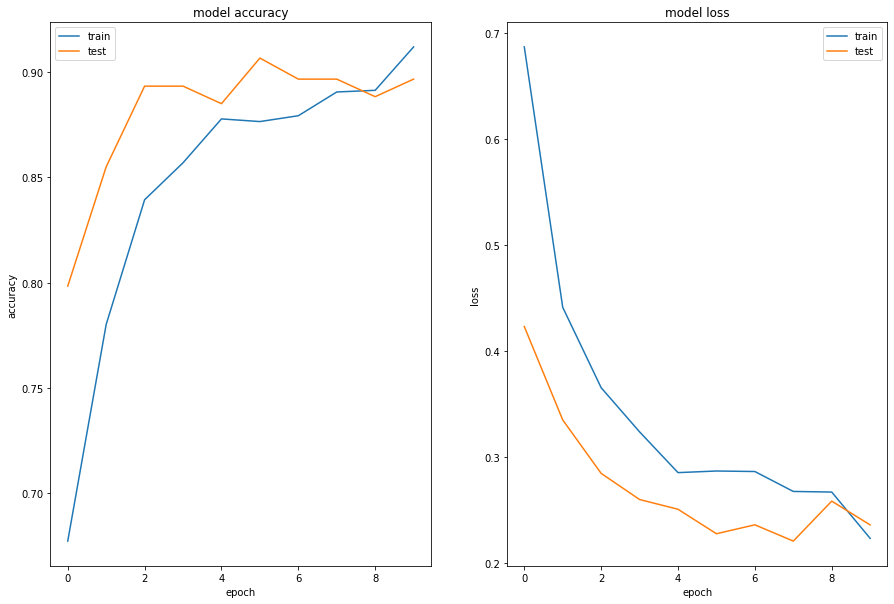

In [29]:
# 绘制训练时准确率、损失率图
plt.figure(figsize=(15,10))
plt.subplot(121)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.show()

Class label: [[0]] Class name: cats
Probability: [[0.9999367]]


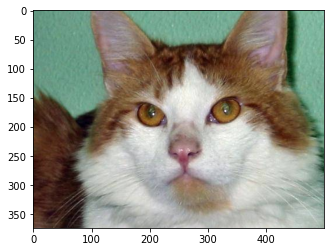

In [30]:
from IPython.display import display
import matplotlib.pyplot as plt
#load and pre-process a new image to make predictions
img_path = 'd.jpg'
img = image.load_img(img_path, target_size=(150, 150))
x = image.img_to_array(img)
x = x / 255.0 #rescale
x = np.expand_dims(x, axis=0)
my_image = imageio.imread(img_path)
imshow(my_image)

#make predictions using the trained model
prob = model.predict(x)
preds = model.predict_classes(x) 
 

for catclass, label in train_label_map.items():
    if preds == label:
        print("Class label:", preds, "Class name:", catclass)
        #if(train_label_map[catclass]=='cats'):
        if(catclass=='cats'):             
            print("Probability:", 1-prob) #print the probability
        else :print("Probability:", prob)    
#print(type(catclass))
#print(type(preds))
#print(train_label_map)
#print(train_label_map[catclass])

Class label: [[1]] Class name: dogs
Probability: [[0.999894]]


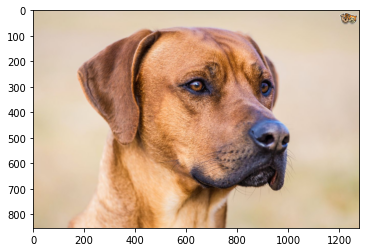

In [31]:
#load and pre-process a new image to make predictions
img_path = 'c.jpg'
img = image.load_img(img_path, target_size=(150, 150))
x = image.img_to_array(img)
x = x / 255.0
x = np.expand_dims(x, axis=0)

#make predictions using the trained model
my_image = imageio.imread(img_path)
imshow(my_image)

prob = model.predict(x)
preds = model.predict_classes(x) 

for catclass, label in train_label_map.items():
    if preds == label:
        print("Class label:", preds, "Class name:", catclass)
        if(catclass=='cats'):             
            print("Probability:", 1-prob) #print the probability
        else :print("Probability:", prob)   